In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('../data/boston_housing.csv')

# Step 1: Handle missing values by imputing with the mean (if necessary)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Step 2: Feature Engineering

# Polynomial Features (Squared and Cubed Terms)
df_imputed['rm_squared'] = df_imputed['rm'] ** 2
df_imputed['rm_cubed'] = df_imputed['rm'] ** 3
df_imputed['lstat_squared'] = df_imputed['lstat'] ** 2
df_imputed['lstat_cubed'] = df_imputed['lstat'] ** 3
df_imputed['age_squared'] = df_imputed['age'] ** 2

# Interaction Features (Feature Pairs Multiplied Together)
df_imputed['crim_tax'] = df_imputed['crim'] * df_imputed['tax']
df_imputed['rm_lstat'] = df_imputed['rm'] * df_imputed['lstat']
df_imputed['dis_ptratio'] = df_imputed['dis'] * df_imputed['ptratio']
df_imputed['nox_rm'] = df_imputed['nox'] * df_imputed['rm']
df_imputed['age_ptratio'] = df_imputed['age'] * df_imputed['ptratio']

# Log Transformations (Log Transformation for Skewed Features)
df_imputed['log_crim'] = np.log1p(df_imputed['crim'])
df_imputed['log_tax'] = np.log1p(df_imputed['tax'])
df_imputed['log_lstat'] = np.log1p(df_imputed['lstat'])
df_imputed['log_dis'] = np.log1p(df_imputed['dis'])
df_imputed['log_age'] = np.log1p(df_imputed['age'])

# Ratio Features (Feature Ratios to Capture Relationships)
df_imputed['tax_to_crim'] = df_imputed['tax'] / (df_imputed['crim'] + 1)
df_imputed['crim_per_room'] = df_imputed['crim'] / (df_imputed['rm'] + 1)
df_imputed['age_to_rooms'] = df_imputed['age'] / (df_imputed['rm'] + 1)
df_imputed['rooms_per_crim'] = df_imputed['rm'] / (df_imputed['crim'] + 1)
df_imputed['lstat_to_dis'] = df_imputed['lstat'] / (df_imputed['dis'] + 1)

# Standardized Features (Standard Scaling of Numerical Features)
scaler = StandardScaler()
df_imputed[['scaled_rm', 'scaled_lstat', 'scaled_dis', 'scaled_nox', 'scaled_age']] = scaler.fit_transform(
    df_imputed[['rm', 'lstat', 'dis', 'nox', 'age']])

# Output the newly created features
df_imputed.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,...,tax_to_crim,crim_per_room,age_to_rooms,rooms_per_crim,lstat_to_dis,scaled_rm,scaled_lstat,scaled_dis,scaled_nox,scaled_age
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,294.141029,0.000834,8.607261,6.533707,0.978389,0.413672,-1.075562,0.140214,-0.144217,-0.120013
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,235.566674,0.003680,10.631990,6.250304,1.531732,0.194274,-0.492439,0.557160,-0.740262,0.367166
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,235.571260,0.003334,7.464875,6.994130,0.675370,1.282714,-1.208727,0.557160,-0.740262,-0.265812
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,215.039182,0.004047,5.726432,6.778577,0.416301,1.016303,-1.361517,1.077737,-0.835284,-0.809889
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,207.661007,0.008476,6.652756,6.685375,0.754722,1.228577,-1.026501,1.077737,-0.835284,-0.511180


In [2]:
# Import necessary libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Check the column names of df_imputed to ensure 'medv' is the target column
print(df_imputed.columns)

# Replace 'price' with 'medv' as the correct target variable name
X = df_imputed.drop(columns=['medv'])  # Drop the correct target column from the features
y = df_imputed['medv']  # Update the target variable to 'medv'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of feature combinations to test
feature_combinations = [
    ['rm', 'lstat', 'age'],  # Original features
    ['rm', 'lstat', 'rm_squared', 'rm_cubed'],  # Polynomial features
    ['crim_tax', 'rm_lstat', 'dis_ptratio'],  # Interaction features
    ['log_crim', 'log_tax', 'log_lstat'],  # Log-transformed features
    ['tax_to_crim', 'crim_per_room'],  # Ratio features
    ['scaled_rm', 'scaled_lstat', 'scaled_dis', 'scaled_nox', 'scaled_age'],  # Scaled features
    ['rm', 'lstat', 'age', 'rm_squared', 'lstat_squared', 'log_crim']  # Combination of original, polynomial, and log-transformed features
]

# Dictionary to store the performance results
results = {}

# Loop through the feature combinations and evaluate performance
for features in feature_combinations:
    # Select the features for the current combination
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    
    # Initialize the model
    model = LinearRegression()
    
    # Train the model
    model.fit(X_train_subset, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_subset)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results[str(features)] = {'MSE': mse, 'R²': r2}

# Display the results
results_df = pd.DataFrame(results).T
results_df.sort_values(by='MSE', ascending=True)  # Sort by MSE for comparison

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'medv', 'rm_squared', 'rm_cubed',
       'lstat_squared', 'lstat_cubed', 'age_squared', 'crim_tax', 'rm_lstat',
       'dis_ptratio', 'nox_rm', 'age_ptratio', 'log_crim', 'log_tax',
       'log_lstat', 'log_dis', 'log_age', 'tax_to_crim', 'crim_per_room',
       'age_to_rooms', 'rooms_per_crim', 'lstat_to_dis', 'scaled_rm',
       'scaled_lstat', 'scaled_dis', 'scaled_nox', 'scaled_age'],
      dtype='object')


,MSE,R²
"['rm', 'lstat', 'age', 'rm_squared', 'lstat_squared', 'log_crim']",18.766980,0.744088
"['rm', 'lstat', 'rm_squared', 'rm_cubed']",22.638543,0.691294
"['log_crim', 'log_tax', 'log_lstat']",24.394251,0.667353
"['scaled_rm', 'scaled_lstat', 'scaled_dis', 'scaled_nox', 'scaled_age']",30.016583,0.590685
"['crim_tax', 'rm_lstat', 'dis_ptratio']",30.815041,0.579797
"['rm', 'lstat', 'age']",31.321541,0.572891
"['tax_to_crim', 'crim_per_room']",63.544482,0.133490


Model Performance Comparison:
                                 MSE        R²
Mixed Features            18.766980  0.744088
Polynomial Features       22.638543  0.691294
Log-Transformed Features  24.394251  0.667353
Scaled Features           30.016583  0.590685
Interaction Features      30.815041  0.579797
Original Features         31.321541  0.572891
Ratio Features            63.544482  0.133490


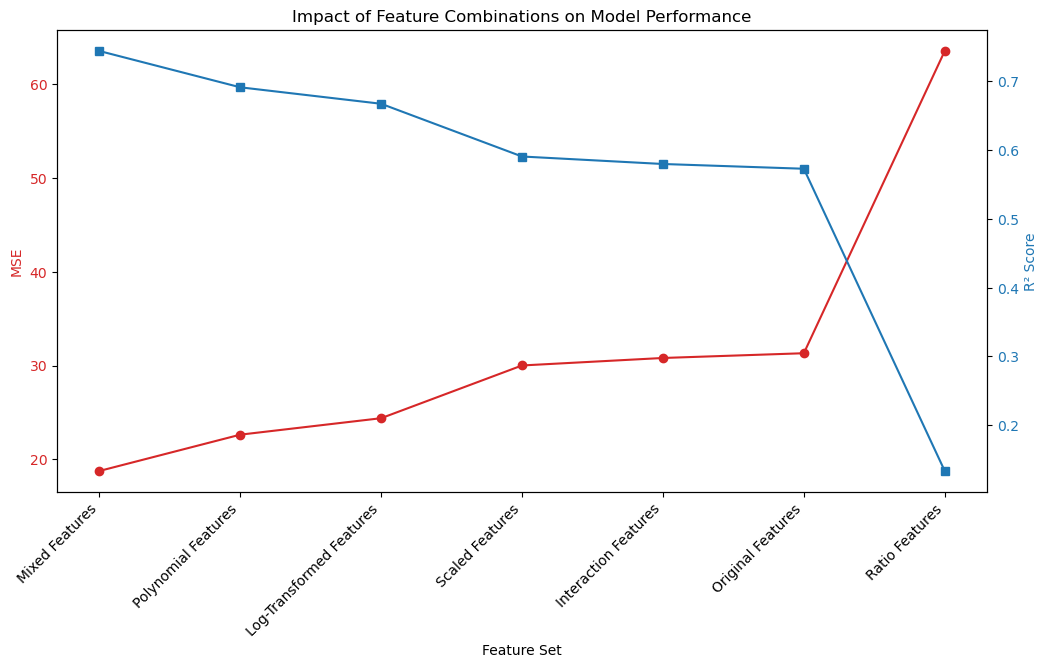

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Create short labels for feature combinations
feature_labels = {
    "['rm', 'lstat', 'age']": "Original Features",
    "['rm', 'lstat', 'rm_squared', 'rm_cubed']": "Polynomial Features",
    "['crim_tax', 'rm_lstat', 'dis_ptratio']": "Interaction Features",
    "['log_crim', 'log_tax', 'log_lstat']": "Log-Transformed Features",
    "['tax_to_crim', 'crim_per_room']": "Ratio Features",
    "['scaled_rm', 'scaled_lstat', 'scaled_dis', 'scaled_nox', 'scaled_age']": "Scaled Features",
    "['rm', 'lstat', 'age', 'rm_squared', 'lstat_squared', 'log_crim']": "Mixed Features",
}

# Convert results dictionary to a DataFrame
results_df = pd.DataFrame(results).T

# Rename feature sets using the shorter labels
results_df.index = results_df.index.map(lambda x: feature_labels.get(x, x))

# Sort the results based on MSE in ascending order (lower MSE is better)
results_df = results_df.sort_values(by='MSE', ascending=True)

# Display the results
print("Model Performance Comparison:\n", results_df)

# Plot MSE and R² score for different feature sets
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MSE
color = 'tab:red'
ax1.set_xlabel('Feature Set')
ax1.set_ylabel('MSE', color=color)
ax1.plot(range(len(results_df.index)), results_df['MSE'], marker='o', color=color, label="MSE")
ax1.tick_params(axis='y', labelcolor=color)

# Set x-ticks properly with shorter labels
ax1.set_xticks(range(len(results_df.index)))  
ax1.set_xticklabels(results_df.index, rotation=45, ha='right')

# Create a second y-axis for R² score
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('R² Score', color=color)
ax2.plot(range(len(results_df.index)), results_df['R²'], marker='s', color=color, label="R² Score")
ax2.tick_params(axis='y', labelcolor=color)

# Add a title
plt.title("Impact of Feature Combinations on Model Performance")

# Show the plot
plt.show()